In [74]:
import pandas as pd
import os
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

In [75]:
def getdata():
    url = "https://api.adzuna.com/v1/api/jobs/us/search/3"

    params = {
    "app_id": "4d93aab4",
    "app_key": "844e65ba7454338b6c860ae041639c67",
    "results_per_page": 50,
    "what": "data analyst",
    "where": "New York",
    "max_days_old": 30,
    "category": "IT-Jobs",
    "sort_by": "date",
    "salary_min": "50000",
    "salary_max": "150000",
    "full_time": 1
    }

    session = Session()
    try:
        response = session.get(url, params = params)
        data = json.loads(response.text)
    except(ConnectionError, Timeout, TooManyRedirects) as e:
        print(e)
    #print(data)
    #normalize json to df
    df = pd.json_normalize(data['results'])
    #add timestamp
    df['timestamp'] = pd.to_datetime('now')
    #ensure correct column order every call
    desired_columns = [
    'id', 'title', 'company.display_name', 'location.display_name',
    'salary_min', 'salary_max', 'created', 'category.label',
    'description', 'redirect_url', 'timestamp'
]
    # Add any missing columns as empty to prevent KeyError
    for col in desired_columns:
        if col not in df.columns:
            df[col] = pd.NA

    # Reorder DataFrame
    df = df[desired_columns]

    #write to csv if file not found, append to csv if found
    if not os.path.isfile(r'C:\Users\cody4\Downloads\data api project\API.csv'):
        df.to_csv(r'C:\Users\cody4\Downloads\data api project\API.csv', header = 'column_names')
    else:
        df.to_csv(r'C:\Users\cody4\Downloads\data api project\API.csv', mode='a', header=False)

In [76]:
def clean():
    #read data
    df = pd.read_csv(r'C:\Users\cody4\Downloads\data api project\API.csv')
    #drop columns 
    df = df.drop(columns = ['category.label', 'Unnamed: 0' ])
    #delete duplicates
    df = df.drop_duplicates('id')
    #rename columns
    df = df.rename(columns  = {'company.display_name': 'company', 'location.display_name': 'location', 'title': 'job_title'})
    #salary
    df['salary'] = (df['salary_min'] + df['salary_max']) / 2

    return df

In [99]:
#create function to create wordcloud
def word_cloud():
#import libraries to create wordcloud
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud
    from wordcloud import STOPWORDS
    import re
    from collections import Counter

    #join all words together where not na and seperate by space
    all_descriptions = ' '.join(df['description'].dropna().astype(str)).lower()
    #delete all special characters and punctuation
    all_descriptions = re.sub(r'[^a-z\s]', '', all_descriptions)
    #split into individual words
    words = all_descriptions.split()
    #append more stop words
    x = ['york', 'ny', 'within', 'city', 'key', 'th', 'overview', 'nearly', 'around', 'iii', 'bring', 'search','built', 'making', 'working', 'end', 'closely', 'centers', 'racial'
    , 'range', 'needed', 'often', 'excellent', 'activities','will','use','youll','description','create','candidate','tools','role','accurate', 'new']
    stop_words = STOPWORDS.union(set(x))
    #remove common stop words
    filtered_words = [word for word in words if word not in stop_words]
    #count word frequeiences
    word_counts = Counter(filtered_words)
    #create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    #plot
    plt.figure(figsize=(15,7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show

In [78]:
from time import time
from time import sleep

for i in range(450):
    #call the api
    getdata()
    print('API call complete')
    #assign the clean data to a df
    df = clean()
    #run every x minutes
    sleep(60*30)
    
exit()

API call complete


KeyboardInterrupt: 

In [101]:
#mean salary
mean_salary = df['salary'].mean()
#mean salary by company
salary_by_company = df.groupby('company')[['salary']].mean()
#top 5 salaries
top_5_sal = df.sort_values('salary', ascending = False).head(5)
#bottom 5 salaries
bottom_5_sal = df.sort_values('salary').head(5)
#average salary by city
location_mean_salary = df.groupby('location')['salary'].mean().round(0)
#find roles with a salaary higher than the average for their location
df['avg_sal_location'] = df['location'].map(location_mean_salary)
df['above_avg_salary'] = df['salary'] > df['avg_sal_location']
above_avg_sal = df[df['above_avg_salary'] == True]
above_avg_sal

,id,job_title,company,location,salary_min,salary_max,description,redirect_url,timestamp,salary,avg_sal_location,above_avg_salary
2,5308988830,"Senior Vice President, Data Quality Sr Lead An...",Citigroup,"New York City, New York",149713.55,149713.55,"Overview of Citi: Citi, the leading global ban...",https://www.adzuna.com/details/5308988830?utm_...,2025-07-17 21:36:34.207464,149713.55,121169.0,True
3,5308983233,Senior Data Analyst,Perchwell,"New York City, New York",140000.00,170000.00,Who We Are Perchwell is the modern real estate...,https://www.adzuna.com/details/5308983233?utm_...,2025-07-17 21:36:34.207464,155000.00,121169.0,True
10,5307120849,"Associate: Data Scientist, Global Research Pre...",Bank of America,"New York City, New York",133632.00,133632.00,The Associate will be a member of the Predicti...,https://www.adzuna.com/details/5307120849?utm_...,2025-07-17 21:36:34.207464,133632.00,121169.0,True
11,5306951729,Lead Data Analyst,SeatGeek,"New York City, New York",125000.00,180000.00,SeatGeek believes live events are powerful exp...,https://www.adzuna.com/details/5306951729?utm_...,2025-07-17 21:36:34.207464,152500.00,121169.0,True
16,5301337633,"Product Manager, Data Platform Product Strateg...",Hearst,"Meadows, Hudson County",120000.00,160000.00,Description Why Hearst? Hearst Magazines’ port...,https://www.adzuna.com/details/5301337633?utm_...,2025-07-17 21:36:34.207464,140000.00,125750.0,True
18,5298227933,Senior AFC Systems Specialist,Apple Bank,"New York City, New York",130000.00,140000.00,"Hybrid/ New York, NY Salary Range: $130,000 - ...",https://www.adzuna.com/details/5298227933?utm_...,2025-07-17 21:36:34.207464,135000.00,121169.0,True
24,5295054607,Senior Business Intelligence Analyst,Oura,"New York City, New York",139000.00,244000.00,Our mission at Oura is to empower every person...,https://www.adzuna.com/details/5295054607?utm_...,2025-07-17 21:36:34.207464,191500.00,121169.0,True
28,5289792770,Technical Onboarding Engineer,Sigma Computing,"New York City, New York",125000.00,150000.00,"Overview: At Sigma, we believe that a seamless...",https://www.adzuna.com/details/5289792770?utm_...,2025-07-17 21:36:34.207464,137500.00,121169.0,True
29,5289718405,Principal Data Security Analyst - Data Classif...,Okta,"New York City, New York",142569.67,142569.67,Get to know Okta Okta is The World’s Identity ...,https://www.adzuna.com/details/5289718405?utm_...,2025-07-17 21:36:34.207464,142569.67,121169.0,True
30,5288654941,Senior Financial Systems Analyst,Amalgamated Bank Of Ny,"Chelsea and Clinton, Manhattan",150000.00,165000.00,Amalgamated Bank is seeking a Senior Financial...,https://www.adzuna.com/details/5288654941?utm_...,2025-07-17 21:36:34.207464,157500.00,112333.0,True


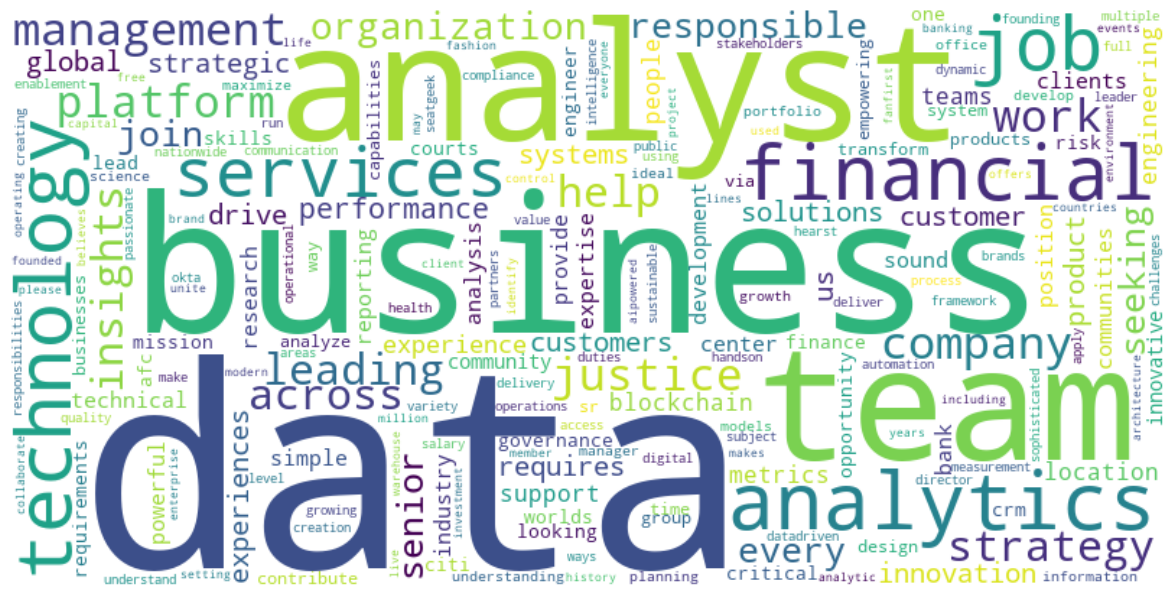

In [100]:
word_cloud()